<a href="https://colab.research.google.com/github/RoshanM-18/Intermediate-Deep-Learning-projects-using-Tensorflow-Keras/blob/main/Encoder_decoder_Chatbot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### Importing the required libraries and downloading the dataset from Kaggle

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow import keras

import os
import shutil
import zipfile
import random
import time
import re
import string

In [ ]:
os.environ["KAGGLE_CONFIG_DIR"] = "/content"

In [ ]:
!chmod 600 "/content/kaggle.json"

In [ ]:
!kaggle datasets download -d grafstor/simple-dialogs-for-chatbot

simple-dialogs-for-chatbot.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
zip_ref = zipfile.ZipFile("/content/simple-dialogs-for-chatbot.zip")
zip_ref.extractall()
zip_ref.close()

#### Reading the txt file and converting it into a two seperate lists of questions and answers

In [ ]:
questions = []
answers = []

with open("/content/dialogs.txt") as f:
  lines = f.read().split("\n")

print(f"There are {len(lines)} dialogues in the corpus.")
print("-"*50)

for line in lines:
  ques, ans = line.split("\t")
  questions.append(ques)
  answers.append(ans)

There are 3725 dialogues in the corpus.
--------------------------------------------------


In [ ]:
len(questions), len(answers)

(3725, 3725)

In [ ]:
for x in range(5):
  print(f"Question: {questions[x]}")
  print(f"Answer: {answers[x]}")
  print("-"*50)

Question: hi, how are you doing?
Answer: i'm fine. how about yourself?
--------------------------------------------------
Question: i'm fine. how about yourself?
Answer: i'm pretty good. thanks for asking.
--------------------------------------------------
Question: i'm pretty good. thanks for asking.
Answer: no problem. so how have you been?
--------------------------------------------------
Question: no problem. so how have you been?
Answer: i've been great. what about you?
--------------------------------------------------
Question: i've been great. what about you?
Answer: i've been good. i'm in school right now.
--------------------------------------------------


#### Clean the dataset and create vocabulary dictionary

In [ ]:
"""im, its, ive, hows, everythings, havent, wasnt, id, shouldnt, wouldnt, thats, youre, doesnt, didnt, itll, shes, 
theres, mightve, youve, macys, lets, ill, whats, cant, dont,"""

'im, its, ive, hows, everythings, havent, wasnt, id, shouldnt, wouldnt, thats, youre, doesnt, didnt, itll, shes, \ntheres, mightve, youve, macys, lets, ill, whats, cant, dont,'

In [ ]:
def clean_text(text):

  text = text.lower()
  text = re.sub(r"\n", "", text)
  text = re.sub(r"can't", "cannot", text)
  text = re.sub(r"let's", "let us", text)
  text = re.sub(r"n't", " not", text)
  text = re.sub(r"\'m", " am", text)
  text = re.sub(r"\'ll", " will", text)
  text = re.sub(r"\'ve", " have", text)
  text = re.sub(r"\'re", " are", text)
  text = re.sub(r"\'d", " would", text)
  text = text.replace("'s", " is")

  text = re.sub(r'[^\w\s]', '', text)

  return text

In [ ]:
cleaned_questions = []

for question in questions:
  cleaned_ques = clean_text(question)
  cleaned_questions.append(cleaned_ques)

cleaned_answers = []
for answer in answers:
  cleaned_ans = clean_text(answer)
  cleaned_answers.append(cleaned_ans)

In [ ]:
for x in range(10):
  print(f"Question: {cleaned_questions[x]}")
  print(f"Answer: {cleaned_answers[x]}")
  print("-"*50)

Question: hi how are you doing
Answer: i am fine how about yourself
--------------------------------------------------
Question: i am fine how about yourself
Answer: i am pretty good thanks for asking
--------------------------------------------------
Question: i am pretty good thanks for asking
Answer: no problem so how have you been
--------------------------------------------------
Question: no problem so how have you been
Answer: i have been great what about you
--------------------------------------------------
Question: i have been great what about you
Answer: i have been good i am in school right now
--------------------------------------------------
Question: i have been good i am in school right now
Answer: what school do you go to
--------------------------------------------------
Question: what school do you go to
Answer: i go to pcc
--------------------------------------------------
Question: i go to pcc
Answer: do you like it there
-----------------------------------------

In [ ]:
questions_words = {}
answers_words = {}

for line in cleaned_questions:
  for word in line.split():
    if word not in questions_words:
      questions_words[word] = 1
    else:
      questions_words[word] += 1

for line in cleaned_answers:
  for word in line.split():
    if word not in answers_words:
      answers_words[word] = 1
    else:
      answers_words[word] += 1

In [ ]:
len(questions_words), len(answers_words)

(2340, 2403)

In [ ]:
questions_vocab_dict = {}
answers_vocab_dict = {}
threshold = 1
count_ques = 0
count_ans = 0

for word, count in questions_words.items():
  if count>threshold:
    questions_vocab_dict[word] = count_ques
    count_ques += 1

for word, count in answers_words.items():
  if count>threshold:
    answers_vocab_dict[word] = count_ans
    count_ans += 1

In [ ]:
count_ques, count_ans

(1401, 1411)

In [ ]:
max_encoder_seq_len = max([len(sentence.split()) for sentence in cleaned_questions])
max_decoder_seq_len = max([len(sentence.split()) for sentence in cleaned_answers])

In [ ]:
max_encoder_seq_len, max_decoder_seq_len

(20, 20)

In [ ]:
tokens = ["<START>", "<END>", "<PAD>", "<UNK>"]

for word in tokens:
  questions_vocab_dict[word] = len(questions_vocab_dict)
  answers_vocab_dict[word] = len(answers_vocab_dict)

In [ ]:
modified_cleaned_answers = []

for sentence in cleaned_answers:
  sent = "<START> " + sentence + " <END>" 
  modified_cleaned_answers.append(sent)

In [ ]:
modified_cleaned_answers[0:5]

['<START> i am fine how about yourself <END>',
 '<START> i am pretty good thanks for asking <END>',
 '<START> no problem so how have you been <END>',
 '<START> i have been great what about you <END>',
 '<START> i have been good i am in school right now <END>']

In [ ]:
max_decoder_seq_len = max([len(sentence.split()) for sentence in modified_cleaned_answers])
max_decoder_seq_len

22

In [ ]:
num_encoder_tokens = len(questions_vocab_dict)+1
num_decoder_tokens = len(answers_vocab_dict)+1

In [ ]:
num_encoder_tokens, num_decoder_tokens

(1406, 1416)

#### creating encoder decoder data

In [ ]:
encoder_input_data = np.zeros(
    (len(cleaned_questions), max_encoder_seq_len, num_encoder_tokens), "float32"
)

decoder_input_data = np.zeros(
    (len(modified_cleaned_answers), max_decoder_seq_len, num_decoder_tokens), "float32"
)

decoder_output_data = np.zeros(
    (len(modified_cleaned_answers), max_decoder_seq_len, num_decoder_tokens), "float32"
)

In [ ]:
encoder_input_data.shape, decoder_input_data.shape, decoder_output_data.shape

((3725, 20, 1406), (3725, 22, 1416), (3725, 22, 1416))

In [ ]:
for index, (input_text, output_text) in enumerate(zip(cleaned_questions, modified_cleaned_answers)):

  for i, word in enumerate(input_text.split()):
    if word in questions_vocab_dict:
      encoder_input_data[index, i, questions_vocab_dict[word]] = 1.0
    else:
      encoder_input_data[index, i, questions_vocab_dict["<UNK>"]] = 1.0
  encoder_input_data[index, i+1:, questions_vocab_dict["<PAD>"]] = 1.0

  for i, word in enumerate(output_text.split()):
    if word in answers_vocab_dict:
      decoder_input_data[index, i, answers_vocab_dict[word]] = 1.0
      if i>0:
        decoder_output_data[index, i-1, answers_vocab_dict[word]] = 1.0
    else:
      decoder_input_data[index, i, answers_vocab_dict["<UNK>"]] = 1.0
      if i>0:
        decoder_output_data[index, i-1, answers_vocab_dict["<UNK>"]] = 1.0
  decoder_input_data[index, i+1:, answers_vocab_dict["<PAD>"]] = 1.0
  decoder_output_data[index, i:, answers_vocab_dict["<PAD>"]] = 1.0

#### Creating encoder-decoder model

In [ ]:
encoder_inputs = keras.layers.Input(shape=(None, num_encoder_tokens))
encoder_lstm = keras.layers.LSTM(256, return_state=True)
encoder_outputs, state_h, state_c = encoder_lstm(encoder_inputs)
encoder_states = [state_h, state_c]

decoder_inputs = keras.layers.Input(shape=(None, num_decoder_tokens))
decoder_lstm = keras.layers.LSTM(256, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs, initial_state=encoder_states)
decoder_dense = keras.layers.Dense(num_decoder_tokens, activation="softmax")
decoder_outputs = decoder_dense(decoder_outputs)

model = keras.Model(inputs=[encoder_inputs, decoder_inputs], 
                    outputs=decoder_outputs)

model.compile(loss=keras.losses.CategoricalCrossentropy(), optimizer=keras.optimizers.Adam(),
              metrics=["accuracy"],)

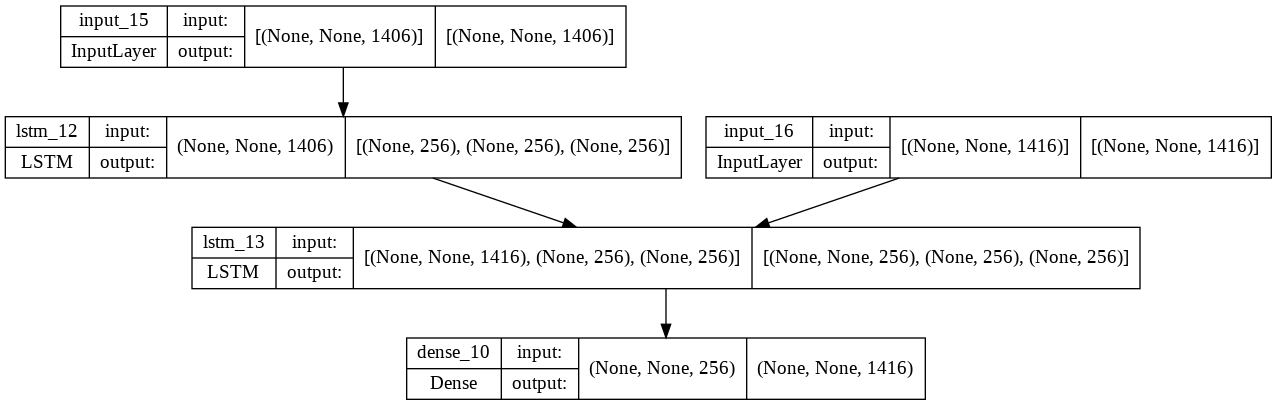

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [ ]:
model.fit([encoder_input_data, decoder_input_data], decoder_output_data, 
          epochs=50, validation_split=0.10, batch_size=64)

Epoch 1/50
53/53 [==============================] - 5s 45ms/step - loss: 3.0145 - accuracy: 0.6376 - val_loss: 2.2713 - val_accuracy: 0.6332
Epoch 2/50
53/53 [==============================] - 1s 27ms/step - loss: 2.0448 - accuracy: 0.6586 - val_loss: 2.2627 - val_accuracy: 0.6332
Epoch 3/50
53/53 [==============================] - 1s 27ms/step - loss: 2.0035 - accuracy: 0.6606 - val_loss: 2.2052 - val_accuracy: 0.6426
Epoch 4/50
53/53 [==============================] - 1s 27ms/step - loss: 1.9353 - accuracy: 0.6683 - val_loss: 2.1475 - val_accuracy: 0.6457
Epoch 5/50
53/53 [==============================] - 1s 27ms/step - loss: 1.8580 - accuracy: 0.6799 - val_loss: 2.0851 - val_accuracy: 0.6505
Epoch 6/50
53/53 [==============================] - 1s 27ms/step - loss: 1.8027 - accuracy: 0.6927 - val_loss: 2.0387 - val_accuracy: 0.6778
Epoch 7/50
53/53 [==============================] - 1s 28ms/step - loss: 1.7687 - accuracy: 0.7016 - val_loss: 2.0256 - val_accuracy: 0.6801
Epoch 8/50
53

#### Inference mode

In [ ]:
inverse_english_vocab = {y:x for x,y in questions_vocab_dict.items()}
inverse_spanish_vocab = {y:x for x,y in answers_vocab_dict.items()}

In [ ]:
encoder_model = keras.Model(encoder_inputs, encoder_states)

decoder_state_input_h = keras.layers.Input(shape=(256,))
decoder_state_input_c = keras.layers.Input(shape=(256,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_outputs, state_h_decoder, state_c_decoder = decoder_lstm(decoder_inputs, initial_state=decoder_states_inputs)

decoder_states = [state_h_decoder, state_c_decoder]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = keras.Model([decoder_inputs]+decoder_states_inputs,
                            [decoder_outputs]+decoder_states)

In [ ]:
def create_encoder_data(input_seq):

  text = clean_text(input_seq)
  encoder_input_inf = np.zeros((1, max_encoder_seq_len, num_encoder_tokens))

  for i, word in enumerate(text.split()):
    if word in questions_vocab_dict:
      encoder_input_inf[0, i, questions_vocab_dict[word]] == 1.0
    else:
      encoder_input_inf[0, i, questions_vocab_dict["<UNK>"]] == 1.0
  encoder_input_inf[0, i+1:, questions_vocab_dict["<PAD>"]] = 1.0

  return encoder_input_inf

In [ ]:
def decode_sequence(input_seq):
    
    input_seq = create_encoder_data(input_seq)
    states_value = encoder_model.predict(input_seq)

    target_seq = np.zeros((1, 1, num_decoder_tokens))
    target_seq[0, 0, answers_vocab_dict["<START>"]] = 1.0

    stop_condition = False
    decoded_sentence = []
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)

        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = inverse_spanish_vocab[sampled_token_index]
        decoded_sentence.append(sampled_char)

        if sampled_char == "<END>" or len(decoded_sentence) >= max_decoder_seq_len:
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1, num_decoder_tokens))
        target_seq[0, 0, sampled_token_index] = 1.0

        # Update states
        states_value = [h, c]

    return " ".join(decoded_sentence[:-1])

In [ ]:
condition = True
while condition:
  input_sent = input()
  decoded_sentence = decode_sequence(input_sent)
  print(decoded_sentence)

  if input_sent=="STOP":
    condition = False

hello man
i am going to the <UNK>
what
i am going to the <UNK>
do not say the same thing 
i am going to be a lot of fun
oh you are 
i am going to be a lot of fun
alright
i am going to the <UNK>
where
i am going to the <UNK>
say something else
i am going to be a lot of fun
how is your girlfriend
i am going to be a lot of fun
okay this is awesome
i am going to be a lot of fun
i am a man
i am going to be a lot of fun
fuck you
i am going to the <UNK>
STOP
i am going to the <UNK>
